Subiectul 1

a)

In [1]:
import pandas as pd

# crearea dataFrame-ului
data = pd.read_csv('date_alegeri_turul2.csv')
data.head()

,Varsta,Sex,Educatie,Venit,Vot
0,45,1,0,8.06,1
1,39,1,1,6.48,1
2,46,1,1,5.48,1
3,55,0,0,5.61,1
4,38,1,1,5.86,1


In [2]:
# Verificam daca exista valori lipsa
print('Numarul valorilor lipsa pentru fiecare variabila:')
print(data.isnull().sum())

Numarul valorilor lipsa pentru fiecare variabila:
Varsta      0
Sex         0
Educatie    0
Venit       0
Vot         0
dtype: int64


In [3]:
# Numărul de duplicate
num_duplicates = data.duplicated().sum()
print("Număr de duplicate:", num_duplicates)

Număr de duplicate: 0


In [6]:
Y = data['Vot'].values

X1 = data['Varsta'].values
X2 = data['Sex'].values
X3 = data['Educatie'].values
X4 = data['Venit'].values

# Verificare balansare date
proportion = Y.mean()  # Procentul de persoane care au votat candidatul A
print("Proportie persoane care au votat canditat A:", proportion)

Proportie persoane care au votat canditat A: 0.792


In [12]:
import pymc as pm
import arviz as az
import numpy as np

# normalizarea datelor
X1 = (X1 - X1.mean()) / X1.std()
X2 = (X2 - X2.mean()) / X2.std()
X3 = (X3 - X3.mean()) / X3.std()
X4 = (X4 - X4.mean()) / X4.std()

with pm.Model() as model:
    # Priori
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta4 = pm.Normal('beta4', mu=0, sigma=1)
    
    # Linear predictor
    mu = alpha + beta1 * X1 + beta2 * X2 + beta3 * X3 + beta4 * X4
    
    # Probabilitate logistică
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=Y)
    
    # Sampling MCMC
    idata = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 86 seconds.


b)

In [13]:
import arviz as az

az.summary(idata, var_names=['beta1', 'beta2', 'beta3', 'beta4'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,0.285,0.127,0.043,0.519,0.001,0.001,9206.0,6214.0,1.0
beta2,-0.418,0.124,-0.649,-0.182,0.001,0.001,9037.0,6093.0,1.0
beta3,0.479,0.128,0.246,0.728,0.001,0.001,9006.0,6276.0,1.0
beta4,0.991,0.142,0.738,1.270,0.002,0.001,8291.0,5720.0,1.0


array([<Axes: title={'center': 'beta1'}>,
       <Axes: title={'center': 'beta2'}>,
       <Axes: title={'center': 'beta3'}>,
       <Axes: title={'center': 'beta4'}>], dtype=object)

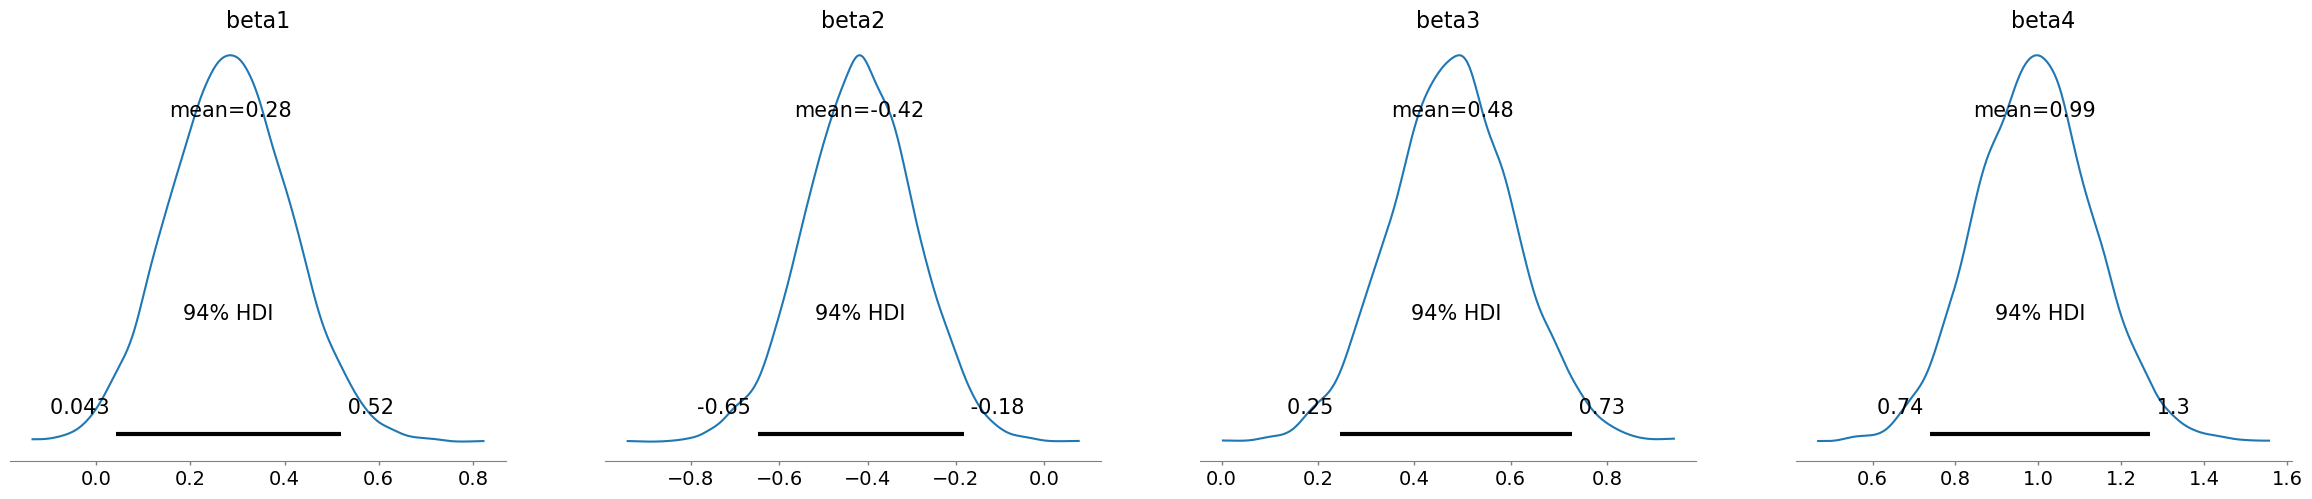

In [14]:
az.plot_posterior(
    idata,
    var_names=["beta1", "beta2", "beta3", "beta4"]
)

Din reprezentarile de mai sus, se poate observa ca modulul mediilor pentru beta 3 si beta 4 sunt cele mai mari dintre cele patru. Concluzionam ca educatia si venitul sunt cei mai buni predictori.

c)

In [31]:
with pm.Model() as model2:
    # Priori
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta4 = pm.Normal('beta4', mu=0, sigma=1)
    
    # Linear predictor
    mu = alpha + beta3 * X3 + beta4 * X4
    
    # Probabilitate logistică
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    # Frontiera de decizie (punctul în care probabilitatea = 0.5)
    bd = pm.Deterministic('bd', -(alpha + beta3 * X3) / beta4)

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=Y)
    
    # Sampling MCMC
    idata2 = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta3, beta4]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 91 seconds.


C:\Users\Roxana\AppData\Local\Temp\ipykernel_13496\2389182583.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bd_hdi = az.hdi(bd_samples_flat, hdi_prob=0.94)  # shape: (N, 2)


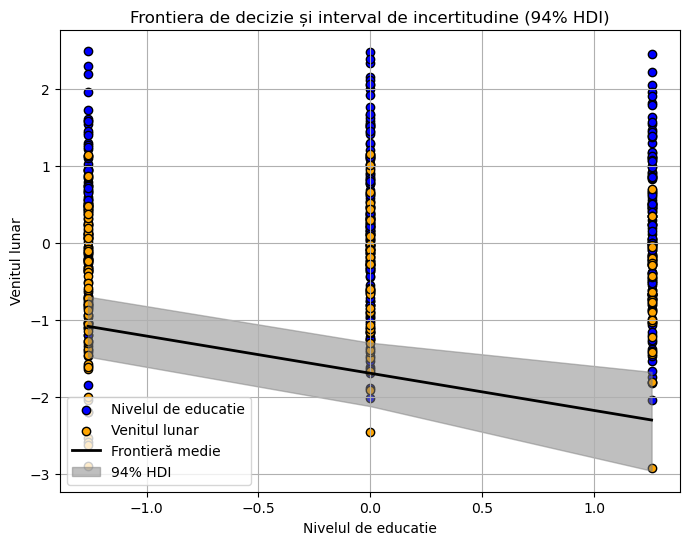

In medie, valoarea frontierei de decizie este: -1.70


In [32]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

bd_samples = idata2.posterior['bd'].values

bd_samples_flat = bd_samples.reshape(-1, bd_samples.shape[-1])  

bd_mean = bd_samples_flat.mean(axis=0)
bd_hdi = az.hdi(bd_samples_flat, hdi_prob=0.94)  # shape: (N, 2)

# Extract HDI bounds
bd_lower, bd_upper = bd_hdi[:, 0], bd_hdi[:, 1]

# Sort X3 values and align with boundary results
sort_idx = np.argsort(X3)
X3_sorted = X3[sort_idx]
bd_mean_sorted = bd_mean[sort_idx]
bd_lower_sorted = bd_lower[sort_idx]
bd_upper_sorted = bd_upper[sort_idx]

# Plot the data
plt.figure(figsize=(8, 6))

# Scatter plot for observed data points
plt.scatter(X3[Y == 1], X4[Y == 1], color='blue', edgecolor='black', label='Nivelul de educatie')
plt.scatter(X3[Y == 0], X4[Y == 0], color='orange', edgecolor='black', label='Venitul lunar')

# Plot the mean decision boundary
plt.plot(X3_sorted, bd_mean_sorted, color='black', lw=2, label='Frontieră medie')

# Plot the 94% HDI region
plt.fill_between(X3_sorted, bd_lower_sorted, bd_upper_sorted, color='gray', alpha=0.5, label='94% HDI')

# Add labels, title, and legend
plt.xlabel('Nivelul de educatie')
plt.ylabel('Venitul lunar')
plt.title('Frontiera de decizie și interval de incertitudine (94% HDI)')
plt.grid(True)
plt.legend()
plt.show()

# Print mean of decision boundary across all samples
bd_mean_value = bd_samples.mean()
print(f'In medie, valoarea frontierei de decizie este: {bd_mean_value:.2f}')


Se observa ca aceste variabile nu sunt indeajuns pentru a face o predictie asupra rezultatului.

d)

In [ ]:
import pymc as pm

# Calcularea WAIC și LOO pentru model
with model:
    trace = pm.sample()
    waic = pm.waic(trace)
    loo = pm.loo(trace)

# Calcularea WAIC și LOO pentru model2
with model2:
    trace = pm.sample()
    waic2 = pm.waic(trace)
    loo2 = pm.loo(trace)

# Compararea rezultatelor
print("Model A - WAIC:", waic, "LOO:", loo)
print("Model C - WAIC:", waic2, "LOO:", loo2)


Initializing NUTS using jitter+adapt_diag...


Subiectul 2

In [24]:
iris = pd.read_csv("iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal


# Selectăm doar cele patru caracteristici
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
X = iris[features].values

# Standardizare
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

true_species = iris["species"]

